In [8]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm 
import exchange_calendars as xcals

In [9]:
smh_price = pd.read_csv('data/SMH.csv')
smh_price

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-05-04,237.509995,237.919998,232.800003,237.199997,235.936432,7312700
1,2021-05-05,239.779999,241.289993,236.949997,238.250000,236.980850,4935800
2,2021-05-06,237.750000,240.630005,235.520004,240.210007,238.930405,6425600
3,2021-05-07,243.570007,245.500000,241.369995,243.600006,242.302353,5385800
4,2021-05-10,241.100006,241.100006,232.380005,232.800003,231.559875,5317000
...,...,...,...,...,...,...,...
248,2022-04-27,225.960007,232.970001,225.800003,227.509995,227.509995,7378200
249,2022-04-28,232.410004,242.669998,229.669998,240.500000,240.500000,9548500
250,2022-04-29,235.929993,241.190002,229.429993,229.850006,229.850006,7243200
251,2022-05-02,229.889999,236.710007,227.729996,236.539993,236.539993,8199600


In [10]:
smh_price['Date'] = pd.to_datetime(smh_price['Date'])
smh_price = smh_price.set_index('Date')
business_day = xcals.get_calendar('NYSE').day
smh_price.index.freq = business_day
smh_close = smh_price['Close']
smh_close

Date
2021-05-04    237.199997
2021-05-05    238.250000
2021-05-06    240.210007
2021-05-07    243.600006
2021-05-10    232.800003
                 ...    
2022-04-27    227.509995
2022-04-28    240.500000
2022-04-29    229.850006
2022-05-02    236.539993
2022-05-03    238.479996
Freq: C, Name: Close, Length: 253, dtype: float64

<AxesSubplot:xlabel='Date'>

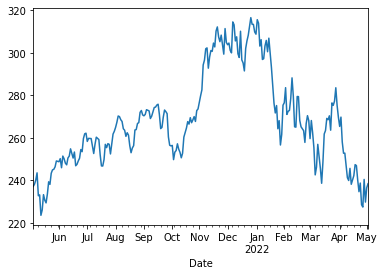

In [11]:
smh_close.plot()

Let's start with SARIMAX for prediction. We need to validate the predictions to make sure they seem reasonable

In [12]:
model = sm.tsa.SARIMAX(smh_close)
results = model.fit()
forecast_results = results.get_forecast('2022-05-06')
summary = forecast_results.summary_frame()
summary

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.14366D+00    |proj g|=  2.02808D-04

At iterate    5    f=  3.14366D+00    |proj g|=  1.62283D-04

At iterate   10    f=  3.14363D+00    |proj g|=  1.77848D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     14     16      1     0     0   1.409D-06   3.144D+00
  F =   3.1435665712821592     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


Close,mean,mean_se,mean_ci_lower,mean_ci_upper
2022-05-04,238.416694,5.527413,227.583163,249.250224
2022-05-05,238.353408,7.815905,223.034516,253.672300
2022-05-06,238.290139,9.571219,219.530894,257.049384


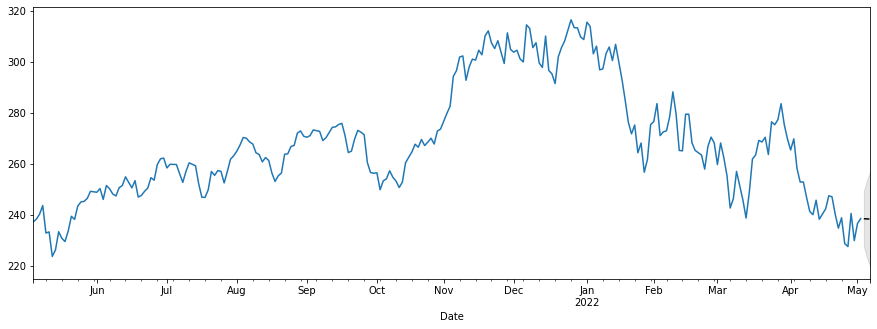

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))
smh_close.plot(ax=ax)
fcast = results.get_forecast('2022-05-06').summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

seems reasonable to me

In [14]:
mean = summary.loc['2022-05-6']['mean']
se = summary.loc['2022-05-6']['mean_se']
dist = norm(mean, se)
forecast = {
    "Less than $240": dist.cdf(240),
    "More than or equal to $240 but less than $260": dist.cdf(260) - dist.cdf(240),
    "More than or equal to $260 but less than $280": dist.cdf(280) - dist.cdf(260),
    "More than or equal to $280 but less than $300": dist.cdf(300) - dist.cdf(280),
    "More than or equal to $300": 1 - dist.cdf(300)
}
{k: f'{round(100*v)}%' for k, v in forecast.items()}

{'Less than $240': '57%',
 'More than or equal to $240 but less than $260': '42%',
 'More than or equal to $260 but less than $280': '1%',
 'More than or equal to $280 but less than $300': '0%',
 'More than or equal to $300': '0%'}